In [2]:
! pip install datasets --upgrade

# **load data**

In [3]:
from datasets import load_dataset

# Load the dataset and download/prepare it
ds = load_dataset("Jinyan1/COLING_2025_MGT_en", download_mode="force_redownload")
#The 'download_mode' is added. To prevent potential issues with the cache, we also included "force_redownload". This will make sure the dataset is downloaded fresh, overwriting any existing files in the cache.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610767 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/261758 [00:00<?, ? examples/s]

In [4]:
train_dataset = load_dataset("Jinyan1/COLING_2025_MGT_en", split="train")
dev_dataset = load_dataset("Jinyan1/COLING_2025_MGT_en", split="dev")

In [5]:
import pandas as pd

df = pd.DataFrame(dev_dataset)
df.head()

,id,source,sub_source,lang,model,label,text
0,e0c8d183-c377-4af0-a12c-2204d75cd5f0,m4gt,peerread,en,gpt4,1,"The paper titled ""A Transition-Based Directed ..."
1,2b6d18d5-993f-486f-a631-986f46ec7ba0,mage,wp,en,text-davinci-003,1,"(Apologies for two submissions, but need to wr..."
2,327667aa-fbe2-46dc-b2e9-31c7618845ca,mage,cmv,en,7B,1,WARNING: WALL OF TEXT!!! I also jump from topi...
3,2fa81a5f-a6da-4cd5-ab0b-22ea4e0464b9,m4gt,outfox,en,cohere,1,Emotion recognition through facial feedback ha...
4,61b935f0-3a00-4441-a185-34216bc5b55a,mage,eli5,en,gpt-3.5-turbo,1,Several things. 1. The cooling effect of air c...


In [6]:
df = df.drop(columns=['id','source','sub_source','lang','model'])
df.head()

,label,text
0,1,"The paper titled ""A Transition-Based Directed ..."
1,1,"(Apologies for two submissions, but need to wr..."
2,1,WARNING: WALL OF TEXT!!! I also jump from topi...
3,1,Emotion recognition through facial feedback ha...
4,1,Several things. 1. The cooling effect of air c...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261758 entries, 0 to 261757
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   261758 non-null  int64 
 1   text    261758 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


# **Download nltk resources**

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Text Cleaning**

In [9]:
def remove_digits(text):
    return re.sub(r'\d+', '', text)

df['text'] = df['text'].apply(lambda x: remove_digits(x))
df['text'] = df['text'].apply(lambda x: x.lower())

In [10]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df.head()

,label,text
0,1,"paper titled ""a transition-based directed acic..."
1,1,"(apologies two submissions, need write.) dear ..."
2,1,warning: wall text!!! also jump topic topic wi...
3,1,emotion recognition facial feedback become sub...
4,1,several things. . cooling effect air currents ...


In [11]:
exclude = string.punctuation

def remove_punctuation(text):
    for char in exclude:
        text = text.replace(char, '')
    return text

df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
df.head()

,label,text
0,1,paper titled a transitionbased directed acicli...
1,1,apologies two submissions need write dear powe...
2,1,warning wall text also jump topic topic withou...
3,1,emotion recognition facial feedback become sub...
4,1,several things cooling effect air currents ta...


In [12]:
def word_tokenizer(text):
    return word_tokenize(text)

df['text'] = df['text'].apply(lambda x: word_tokenizer(x))
df.head()

,label,text
0,1,"[paper, titled, a, transitionbased, directed, ..."
1,1,"[apologies, two, submissions, need, write, dea..."
2,1,"[warning, wall, text, also, jump, topic, topic..."
3,1,"[emotion, recognition, facial, feedback, becom..."
4,1,"[several, things, cooling, effect, air, curren..."


In [13]:
def lemma(text):
    return ' '.join([WordNetLemmatizer().lemmatize(word) for word in text])
df['text'] = df['text'].apply(lambda x: lemma(x))
df.head()

,label,text
0,1,paper titled a transitionbased directed acicli...
1,1,apology two submission need write dear powerfa...
2,1,warning wall text also jump topic topic withou...
3,1,emotion recognition facial feedback become sub...
4,1,several thing cooling effect air current takin...


# **Encoding Data (Tokenizer)**

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['text']
y = df['label']

tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")

tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_seq, padding='post', maxlen=200, truncating='post')

# **Splitting Data**

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# **Building Models**

## LSTM (long-short term memory)

In [17]:
lstm_model = Sequential([
    Embedding(input_dim=100000, output_dim=128, input_length=200),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[earlyStopping,reduce_lr])

Epoch 1/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 140s 27ms/step - accuracy: 0.9704 - loss: 0.0883 - val_accuracy: 0.8689 - val_loss: 0.3920 - learning_rate: 2.0000e-04
Epoch 2/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - accuracy: 0.9809 - loss: 0.0617 - val_accuracy: 0.8737 - val_loss: 0.4536 - learning_rate: 2.0000e-04
Epoch 3/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - accuracy: 0.9862 - loss: 0.0466 - val_accuracy: 0.8728 - val_loss: 0.4889 - learning_rate: 2.0000e-04
Epoch 4/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.9882 - loss: 0.0397 - val_accuracy: 0.8718 - val_loss: 0.5568 - learning_rate: 2.0000e-04
Epoch 5/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - accuracy: 0.9919 - loss: 0.0284 - val_accuracy: 0.8700 - val_loss: 0.6114 - learning_rate: 1.0000e-04
Epoch 6/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - accuracy: 0.9934 - loss: 0.0237 - val_accuracy: 0.8684 - val_loss: 0.6740 - learning_rate: 1.0000e-04


In [25]:
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

1636/1636 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8681 - loss: 0.4044

Test Accuracy: 86.78%


In [27]:
import matplotlib.pyplot as plt

def plot_metrics(history, title):
    # Get metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

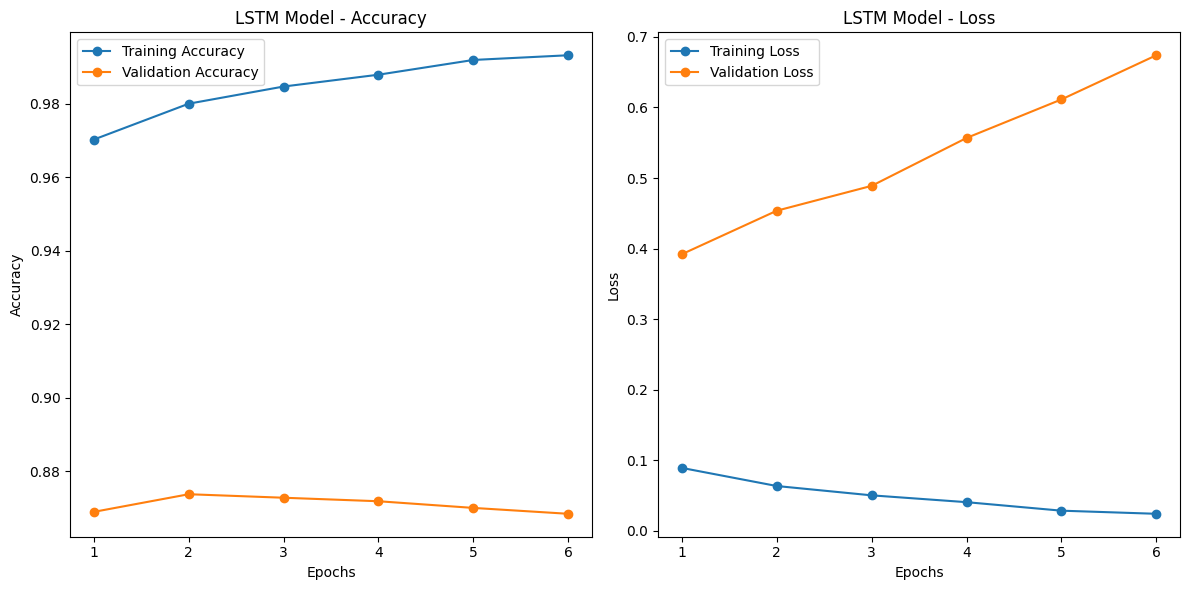

In [29]:
plot_metrics(lstm_history, "LSTM Model")

## CNN (convolution neural network )

In [31]:
# CNN Model Implementation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential([
    Embedding(input_dim=100000, output_dim=128, input_length=200),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                           callbacks=[earlyStopping, reduce_lr])

Epoch 1/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.7626 - loss: 0.4771 - val_accuracy: 0.8417 - val_loss: 0.3494 - learning_rate: 0.0010
Epoch 2/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9037 - loss: 0.2379 - val_accuracy: 0.8662 - val_loss: 0.3266 - learning_rate: 0.0010
Epoch 3/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9633 - loss: 0.1013 - val_accuracy: 0.8659 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 4/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9822 - loss: 0.0519 - val_accuracy: 0.8565 - val_loss: 0.5859 - learning_rate: 0.0010
Epoch 5/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9898 - loss: 0.0310 - val_accuracy: 0.8665 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 6/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9952 - loss: 0.0148 - val_accuracy: 0.8673 - val_loss: 0.8909 - learning_rate: 2.0000e-04
Epoch 7/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy:

## RNN (recurrent neural network )

In [36]:
# Define callbacks globally for all models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# RNN Model
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=100000, output_dim=128, input_length=200),
        SimpleRNN(128, return_sequences=True),  # Output: (batch_size, 100, 128)
        Dropout(0.5),
        SimpleRNN(64, return_sequences=False),  # Output: (batch_size, 64)
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_history=rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
              callbacks=[earlyStopping, reduce_lr], verbose=1)
rnn_pred = (rnn_model.predict(X_test) > 0.5).astype(int).flatten()

Epoch 1/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 194s 36ms/step - accuracy: 0.6095 - loss: 0.6764 - val_accuracy: 0.6238 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 2/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 196s 35ms/step - accuracy: 0.6232 - loss: 0.6635 - val_accuracy: 0.6238 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 3/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 194s 34ms/step - accuracy: 0.6267 - loss: 0.6591 - val_accuracy: 0.6238 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 4/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 201s 34ms/step - accuracy: 0.6296 - loss: 0.6454 - val_accuracy: 0.6297 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 5/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 183s 35ms/step - accuracy: 0.6438 - loss: 0.6307 - val_accuracy: 0.6273 - val_loss: 0.6435 - learning_rate: 0.0010
Epoch 6/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 202s 35ms/step - accuracy: 0.6426 - loss: 0.6297 - val_accuracy: 0.6405 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 7/20
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 203s 35ms/step -

## ANN ( artificial neural network )

In [33]:
# ANN Model Implementation
# Flattening our sequences for the dense model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_flat.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train ANN model
ann_history = ann_model.fit(X_train_flat, y_train, epochs=20, batch_size=128, validation_split=0.2,
                           callbacks=[earlyStopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6022 - loss: 0.6943 - val_accuracy: 0.6343 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 2/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6291 - loss: 0.6447 - val_accuracy: 0.6359 - val_loss: 0.6346 - learning_rate: 0.0010
Epoch 3/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6378 - loss: 0.6360 - val_accuracy: 0.6415 - val_loss: 0.6325 - learning_rate: 0.0010
Epoch 4/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6441 - loss: 0.6292 - val_accuracy: 0.6449 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 5/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6478 - loss: 0.6265 - val_accuracy: 0.6458 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 6/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6491 - loss: 0.6238 - val_accuracy: 0.6434 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 7/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6519 -

# **Models Evaluation**

In [37]:
# Evaluate individual models
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {cnn_test_accuracy * 100:.2f}%")

rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test, y_test)
print(f"RNN Test Accuracy: {rnn_test_accuracy * 100:.2f}%")

ann_test_loss, ann_test_accuracy = ann_model.evaluate(X_test_flat, y_test)
print(f"ANN Test Accuracy: {ann_test_accuracy * 100:.2f}%")

print(f"LSTM Test Accuracy: {test_accuracy * 100:.2f}%")

1636/1636 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8657 - loss: 0.3315
CNN Test Accuracy: 86.62%
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6414 - loss: 0.6379
RNN Test Accuracy: 63.97%
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6553 - loss: 0.6232
ANN Test Accuracy: 65.62%
LSTM Test Accuracy: 86.78%


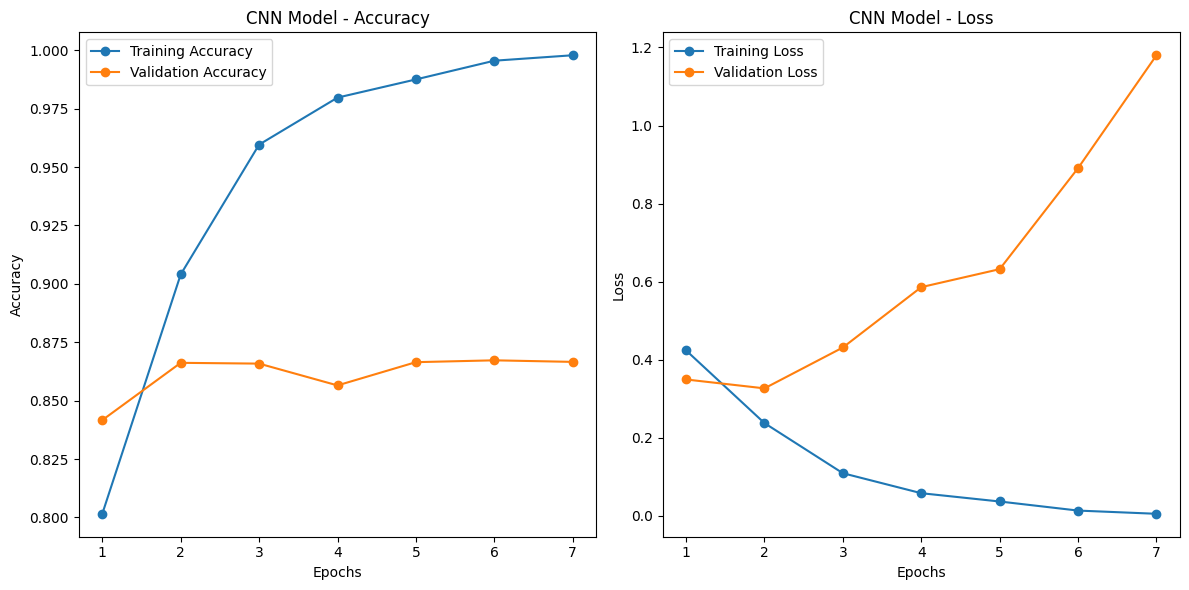

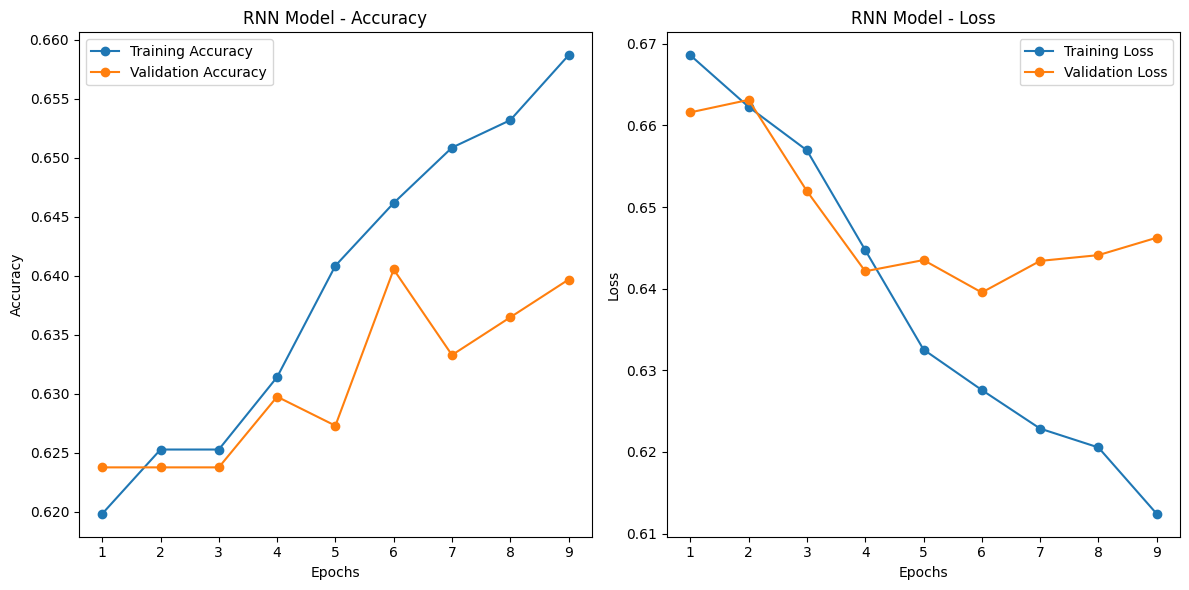

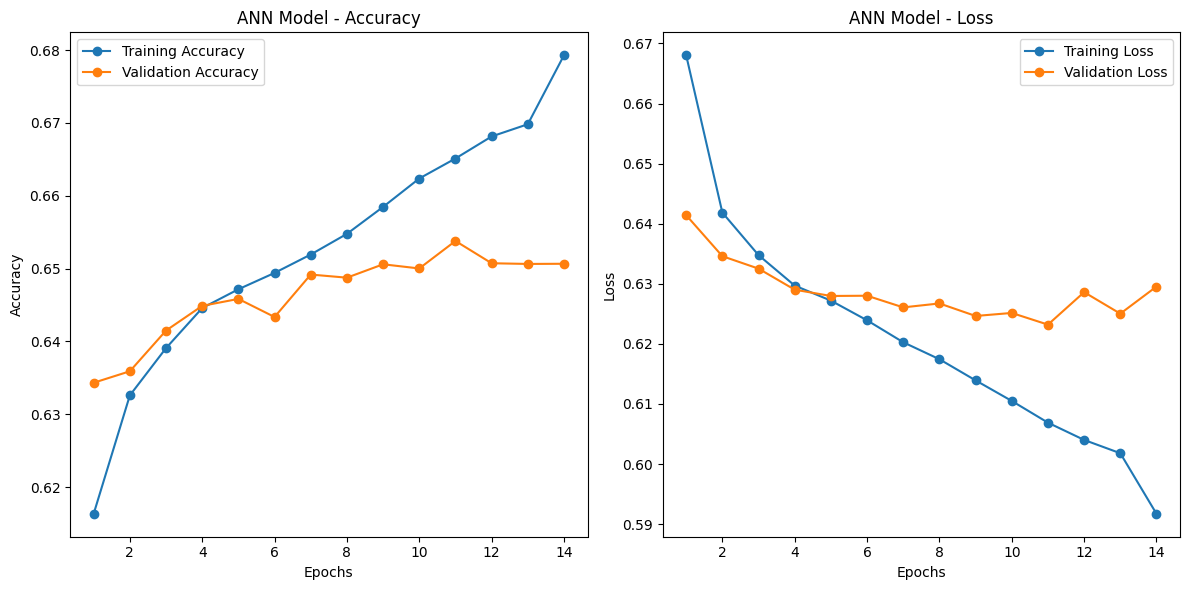

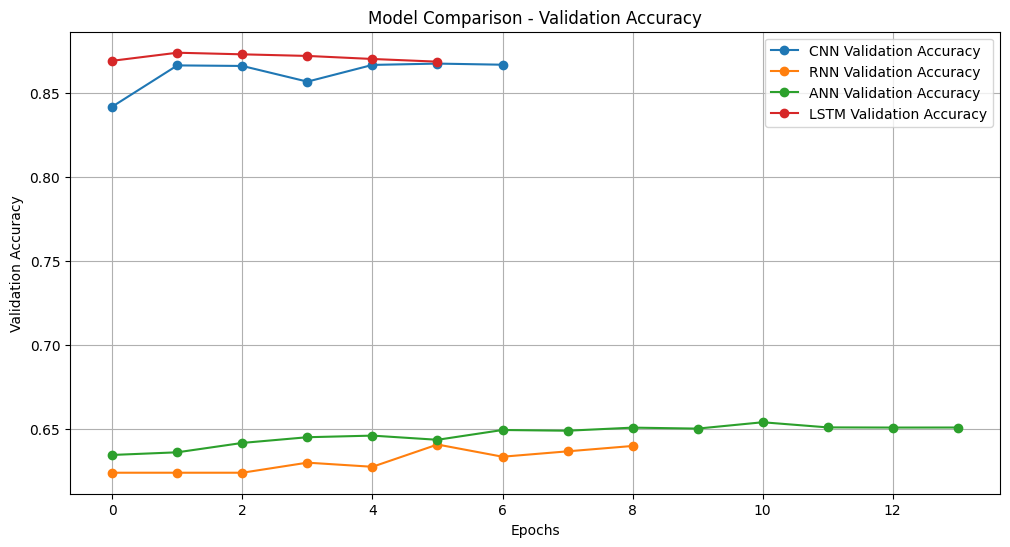

In [38]:

# Plot metrics for all models
plot_metrics(cnn_history, "CNN Model")
plot_metrics(rnn_history, "RNN Model")
plot_metrics(ann_history, "ANN Model")

# Compare validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy', marker='o')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy', marker='o')
plt.plot(ann_history.history['val_accuracy'], label='ANN Validation Accuracy', marker='o')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy', marker='o')
plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Generate predictions from each model
cnn_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
rnn_pred = (rnn_model.predict(X_test) > 0.5).astype("int32")
lstm_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
ann_pred = (ann_model.predict(X_test_flat) > 0.5).astype("int32")

# Reshape predictions to 1D arrays
cnn_pred = cnn_pred.reshape(-1)
rnn_pred = rnn_pred.reshape(-1)
lstm_pred = lstm_pred.reshape(-1)
ann_pred = ann_pred.reshape(-1)

1636/1636 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
1636/1636 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


# **Voting**

In [40]:
# Majority voting implementation
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Perform majority voting
voting_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    votes = [cnn_pred[i], rnn_pred[i], lstm_pred[i], ann_pred[i]]
    voting_pred[i] = 1 if sum(votes) >= 2 else 0  # Majority rule (at least 2 votes)

# Calculate metrics for the voting model
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_precision = precision_score(y_test, voting_pred)
voting_recall = recall_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred)
voting_cm = confusion_matrix(y_test, voting_pred)

print(f"\nVoting Ensemble Results:")
print(f"Accuracy: {voting_accuracy * 100:.2f}%")
print(f"Precision: {voting_precision:.4f}")
print(f"Recall: {voting_recall:.4f}")
print(f"F1 Score: {voting_f1:.4f}")
print(f"Confusion Matrix:\n{voting_cm}")


Voting Ensemble Results:
Accuracy: 72.02%
Precision: 0.6944
Recall: 0.9824
F1 Score: 0.8137
Confusion Matrix:
[[ 5719 14074]
 [  573 31986]]


# **Evaluation Metrices**

In [41]:
# Compare all models with metrics
model_names = ['CNN', 'RNN', 'LSTM', 'ANN', 'Voting Ensemble']

# Calculate individual model metrics
cnn_accuracy = accuracy_score(y_test, cnn_pred)
cnn_precision = precision_score(y_test, cnn_pred)
cnn_recall = recall_score(y_test, cnn_pred)
cnn_f1 = f1_score(y_test, cnn_pred)

rnn_accuracy = accuracy_score(y_test, rnn_pred)
rnn_precision = precision_score(y_test, rnn_pred)
rnn_recall = recall_score(y_test, rnn_pred)
rnn_f1 = f1_score(y_test, rnn_pred)

lstm_accuracy = accuracy_score(y_test, lstm_pred)
lstm_precision = precision_score(y_test, lstm_pred)
lstm_recall = recall_score(y_test, lstm_pred)
lstm_f1 = f1_score(y_test, lstm_pred)

ann_accuracy = accuracy_score(y_test, ann_pred)
ann_precision = precision_score(y_test, ann_pred)
ann_recall = recall_score(y_test, ann_pred)
ann_f1 = f1_score(y_test, ann_pred)

# Create lists of metrics
accuracies = [cnn_accuracy, rnn_accuracy, lstm_accuracy, ann_accuracy, voting_accuracy]
precisions = [cnn_precision, rnn_precision, lstm_precision, ann_precision, voting_precision]
recalls = [cnn_recall, rnn_recall, lstm_recall, ann_recall, voting_recall]
f1_scores = [cnn_f1, rnn_f1, lstm_f1, ann_f1, voting_f1]

# **Plot Comparison**

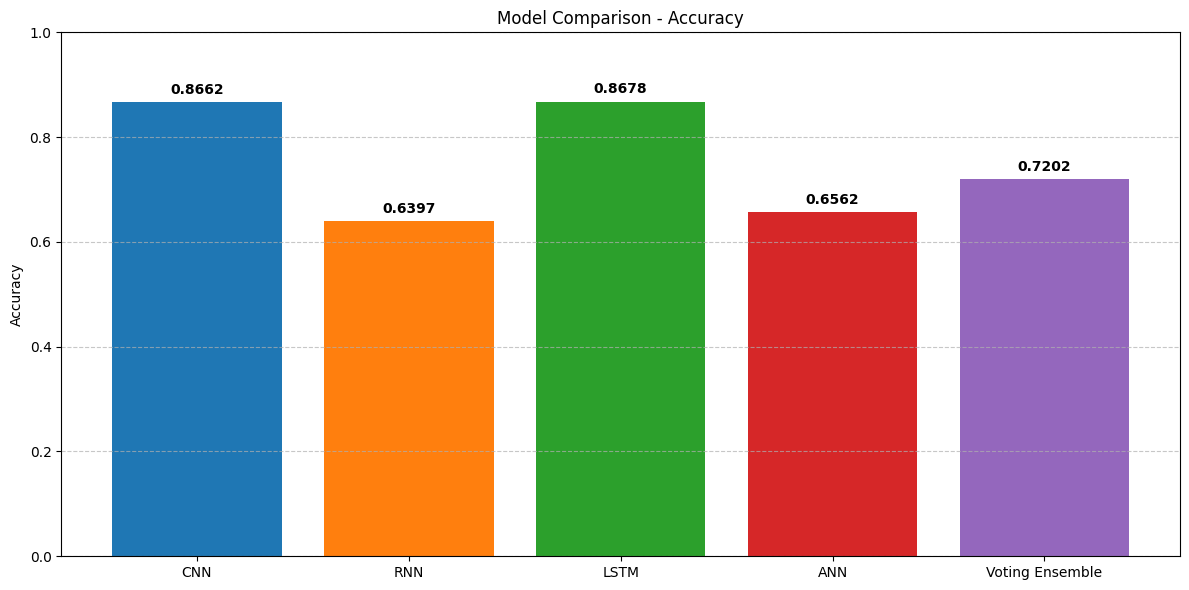

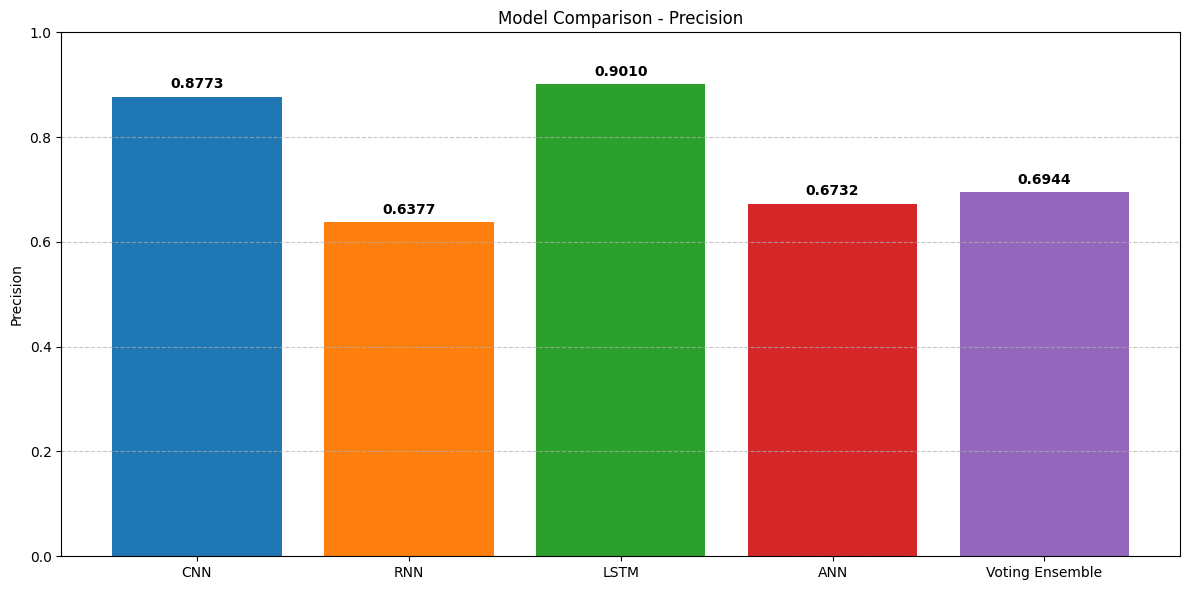

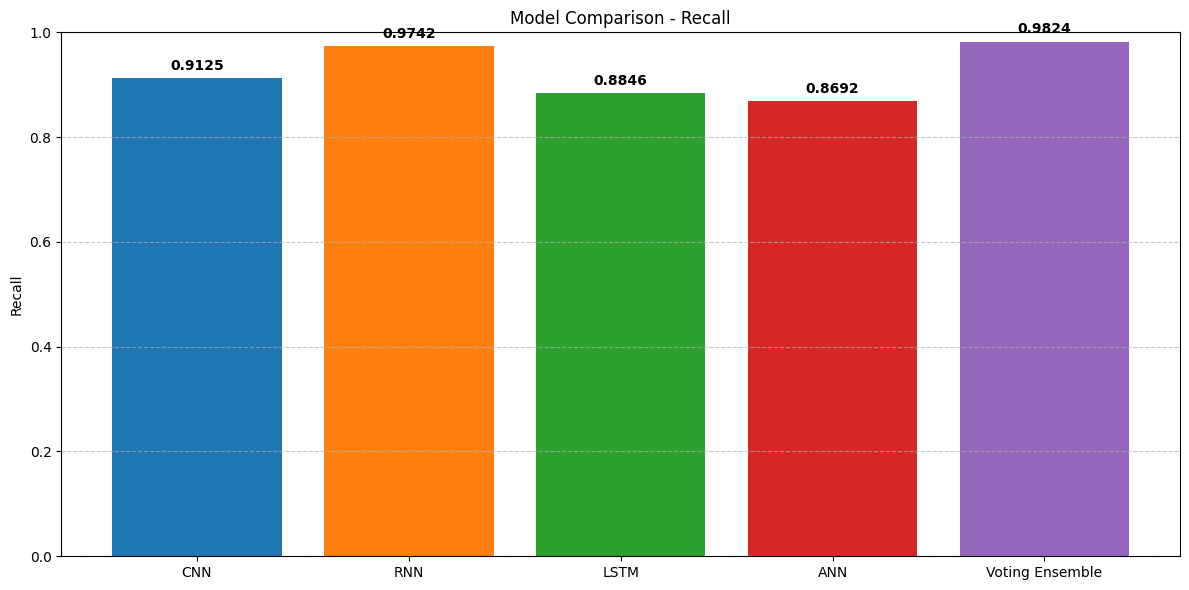

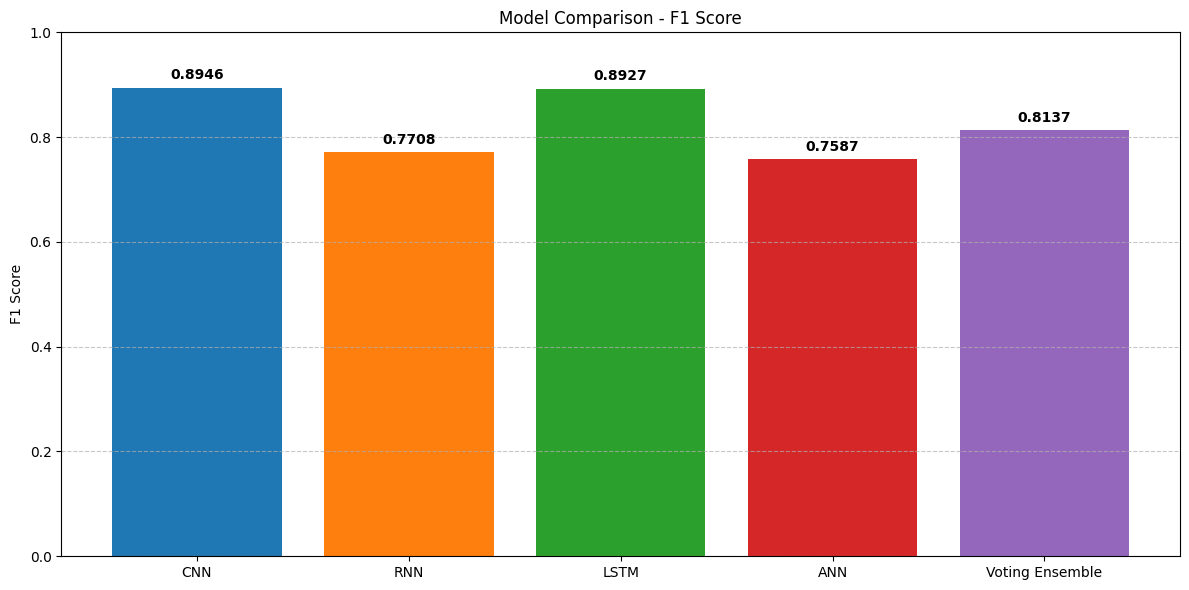

In [42]:
# Plot comparison bar charts
import matplotlib.pyplot as plt

def plot_metric_comparison(metric_values, metric_name):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    plt.title(f'Model Comparison - {metric_name}')
    plt.ylabel(metric_name)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Plot each metric comparison
plot_metric_comparison(accuracies, 'Accuracy')
plot_metric_comparison(precisions, 'Precision')
plot_metric_comparison(recalls, 'Recall')
plot_metric_comparison(f1_scores, 'F1 Score')

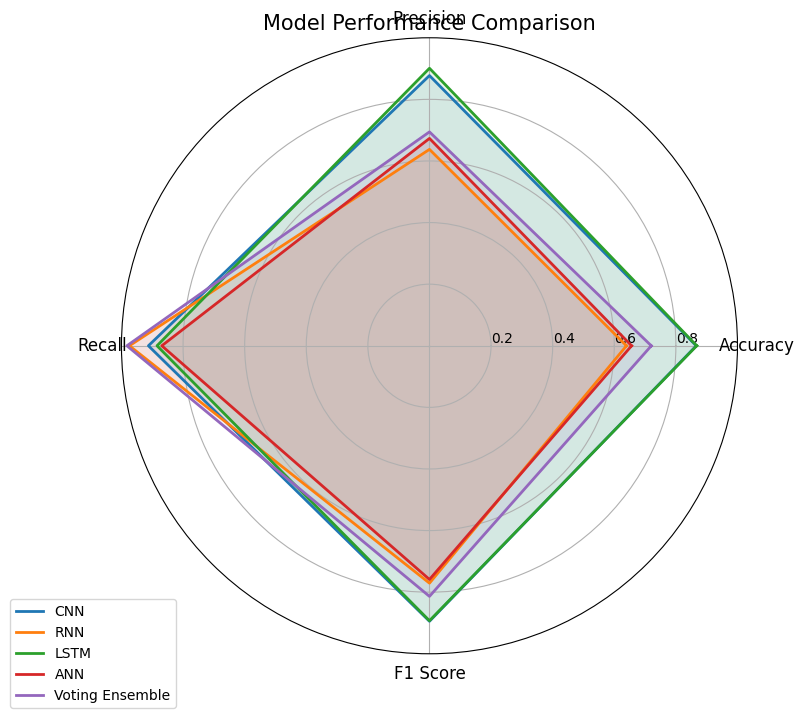

In [43]:
# Create radar chart for overall model comparison
import numpy as np
import matplotlib.pyplot as plt

def radar_plot(models, metrics_names, metrics_values):
    # Number of variables
    N = len(metrics_names)

    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics_names, size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], size=10)
    plt.ylim(0, 1)

    # Plot each model
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, model in enumerate(models):
        values = metrics_values[i]
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=15)
    plt.show()

# Prepare data for radar plot
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [
    [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1],
    [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1],
    [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1],
    [ann_accuracy, ann_precision, ann_recall, ann_f1],
    [voting_accuracy, voting_precision, voting_recall, voting_f1]
]

# Create the radar plot
radar_plot(model_names, metrics_names, metrics_values)

# **Saving Models**

In [44]:
# Save all models
cnn_model.save('cnn_model.h5')
rnn_model.save('rnn_model.h5')
ann_model.save('ann_model.h5')

# Save voting results
import pandas as pd

# Create a DataFrame with all results
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1_Score': f1_scores
})

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nAll models and results saved successfully!")

# Display the results table
results_df.set_index('Model', inplace=True)
results_df


All models and results saved successfully!


,Accuracy,Precision,Recall,F1_Score
Model,,,,
CNN,0.866213,0.877285,0.912528,0.894559
RNN,0.639670,0.637652,0.974231,0.770801
LSTM,0.867761,0.900989,0.884579,0.892708
ANN,0.656212,0.673193,0.869161,0.758727
Voting Ensemble,0.720221,0.694442,0.982401,0.813696
